# 0. Import Dependencies

In [299]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


# 1. Data Preparation

## 1.1 Data Load

In [300]:
classes = ['Ferrari', 'McLaren', 'Mercedes', 'RedBull']

In [301]:
class DataSet(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [302]:
dataset = DataSet(csv_file="./data/f1_classification/f111.csv",
                  root_dir="./data/f1_classification/",
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize((28,28)),
                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                  ]))
len(dataset)

279

## 1.2 Data Preproccesing

In [303]:
data_lengths = (int(len(dataset)*.75), len(dataset) - int(len(dataset)*.75))

In [304]:
train_data, test_data = torch.utils.data.random_split(dataset, data_lengths)

In [305]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader= DataLoader(test_data, batch_size=8, shuffle=True)

## 1.3 Data Visulization

In [306]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([8, 3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


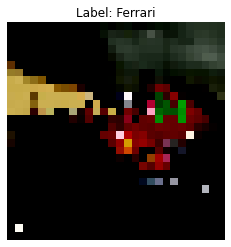

In [307]:
image, label = dataset[0]

plt.imshow(np.transpose(image.numpy(), (1,2,0)))
plt.title(f"Label: {classes[label]}")
plt.axis('off')
plt.show()

# 2. Model Training

In [308]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, (3,3))
        self.conv2 = nn.Conv2d(16, 32, (3,3))
        self.conv3 = nn.Conv2d(32, 64, (3,3))
        self.maxpool = nn.MaxPool2d((2,2))
        self.dense1 = nn.Linear(64, 256)
        self.dense2 = nn.Linear(256, 512)
        self.dense3 = nn.Linear(512, 4)
        self.flatten = nn.Flatten()
        
        self.elu = nn.ELU()
        self.softmax = nn.Softmax()
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.elu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.elu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.elu(x)
        x = self.maxpool(x)
        
        x = self.flatten(x)
        
        x = self.dense1(x)
        x = self.elu(x)
        
        x = self.dense2(x)
        x = self.elu(x)
        
        x = self.dense3(x)
        x = self.elu(x)
        
        output = self.softmax(x)
        
        return output

In [309]:
model = Model()

In [310]:
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10

In [311]:
def train(model, train_loader, val_loader, epochs, optimizer, criterion):
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        for i, (images, label) in enumerate(train_loader):
            
            
            optimizer.zero_grad()
            
            pred = model(images)
            loss = criterion(pred, label)
            
            loss.backward()
            optimizer.step()
            if i % 5 == 0:
                val_num_samples = 0
                val_num_correct = 0
                
                for image, label in val_loader: 
                    pred = model(image)
                    pred = np.argmax(pred.data, axis=1)
                    
                    val_num_samples += pred.size(0)
                    val_num_correct += (pred == label).sum().item()
                    
                val_accuracy = val_num_correct / val_num_samples * 100
                
        acc_list.append(val_accuracy)
        loss_list.append(loss.item())
        print(f"Epoch [{epochs}/{epoch+1}], loss: {loss:.4f}, acc: %{val_accuracy:.2f}")
        
    return loss_list, acc_list
            

In [312]:
loss_list, acc_list = train(model, train_loader, test_loader, epochs, optimizer, criterion)

Epoch [10/1], loss: 1.3666, acc: %48.57
Epoch [10/2], loss: 1.4276, acc: %44.29
Epoch [10/3], loss: 1.4279, acc: %55.71
Epoch [10/4], loss: 0.7617, acc: %60.00
Epoch [10/5], loss: 0.9412, acc: %74.29
Epoch [10/6], loss: 1.2080, acc: %70.00
Epoch [10/7], loss: 0.7447, acc: %74.29
Epoch [10/8], loss: 0.7439, acc: %78.57
Epoch [10/9], loss: 0.7466, acc: %75.71
Epoch [10/10], loss: 1.0024, acc: %74.29


# 3. Model Evaluate

In [313]:
def test(model, test_loader):
    num_samples = 0
    num_correct = 0
    model.eval()
    
    with torch.no_grad():
        for image, label in test_loader:
            pred = model(image)
            num_correct += (np.argmax(pred, axis=1) == label).sum().item()
            num_samples += pred.size(0)
        print(f"Accuracy: %{(num_correct/num_samples)*100:.2f}")
        model.train()
        

In [314]:
test(model, test_loader)

Accuracy: %72.86


In [315]:
test(model, train_loader)

Accuracy: %87.56


# 4. Model Save

In [316]:
torch.save(model, "model/f1_classification_model.pth")

# 5. Model Summary

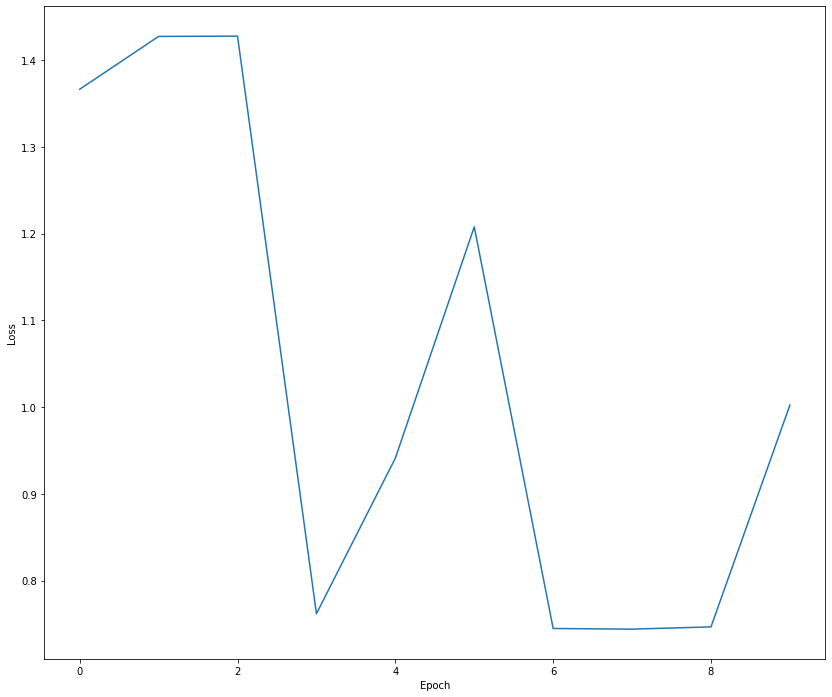

In [327]:
plt.figure(figsize=(14,12))
plt.plot([loss.item() for loss in loss_list])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

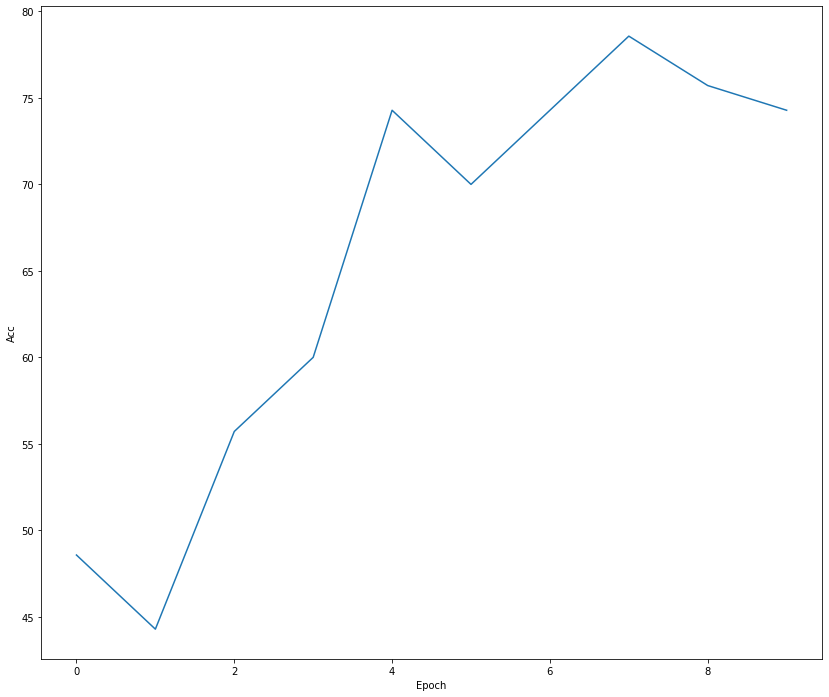

In [328]:
plt.figure(figsize=(14,12))
plt.plot(acc_list)
plt.xlabel('Epoch')
plt.ylabel('Acc')

plt.show()